In [5]:
!pip install pyportfolioopt

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import pypfopt as ppf

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
from pypfopt import BlackLittermanModel, black_litterman

import matplotlib.pyplot as plt

In [7]:
def fetch_stock_data(tickers, start_date, end_date):
    # Download stock data
    stock_data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return stock_data


In [8]:
tickers = "MSFT AMZN NAT BAC"
start_date = "2021-01-01"
end_date = "2024-01-19"
stock_data = fetch_stock_data(tickers, start_date, end_date)
market_data = fetch_stock_data('SPY', start_date, end_date).to_frame()
stock_data
market_data

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2021-01-04,352.767120
2021-01-05,355.196777
2021-01-06,357.320374
2021-01-07,362.629181
2021-01-08,364.695374
...,...
2024-01-11,476.350006
2024-01-12,476.679993
2024-01-16,474.929993


In [9]:
# Calculate expected returns and sample covariance
# mu = expected_returns.mean_historical_return(prices=stock_data)
# mu = expected_returns.ema_historical_return(prices=stock_data)
mu = expected_returns.capm_return(prices=stock_data, market_prices=market_data, risk_free_rate=0.05)
mu

AMZN    0.132069
BAC     0.103978
MSFT    0.117216
NAT     0.089270
Name: mkt, dtype: float64

In [10]:
# Sigma = risk_models.risk_matrix(stock_data, method="sample_cov")
Sigma = risk_models.risk_matrix(stock_data, method="ledoit_wolf")
Sigma

,AMZN,BAC,MSFT,NAT
AMZN,0.139082,0.032634,0.067184,0.022624
BAC,0.032634,0.082441,0.021671,0.029334
MSFT,0.067184,0.021671,0.078760,0.017750
NAT,0.022624,0.029334,0.017750,0.384453


In [26]:
# My views
P = np.array([[1,0,0,0],[0,0,1,0]])
Q = np.array([0.30, 0.10])
confidences = [0.9,0.3]

In [28]:
bl = BlackLittermanModel(Sigma, pi=mu, Q=Q, P=P, omega="idzorek", view_confidences=confidences)
ret_bl = bl.bl_returns()
cov_bl = bl.bl_cov()

print(ret_bl, cov_bl)

AMZN    0.280609
BAC     0.136546
MSFT    0.171063
NAT     0.110795
dtype: float64           AMZN       BAC      MSFT       NAT
AMZN  0.139768  0.032786  0.067449  0.022726
BAC   0.032786  0.086207  0.021966  0.030550
MSFT  0.067449  0.021966  0.080711  0.018062
NAT   0.022726  0.030550  0.018062  0.403497


In [18]:
# plotting.plot_covariance(Sigma, plot_correlation=True)

In [29]:
### Compute Minimum Variance Portfolio using PyPortfolioOpt
# Create an EfficientFrontier object
ef = EfficientFrontier(ret_bl, cov_bl)
# Calculate the minimum volatility portfolio weights
raw_weights = ef.min_volatility()
raw_weights

cleaned_weights = ef.clean_weights()
cleaned_weights

OrderedDict([('AMZN', 0.0183),
             ('BAC', 0.43342),
             ('MSFT', 0.47809),
             ('NAT', 0.07018)])

In [30]:
ef.portfolio_performance(verbose=True)

Expected annual return: 15.4%
Annual volatility: 22.5%
Sharpe Ratio: 0.60


(0.15387783429498608, 0.22496678918095117, 0.5951004358572322)

<Axes: >

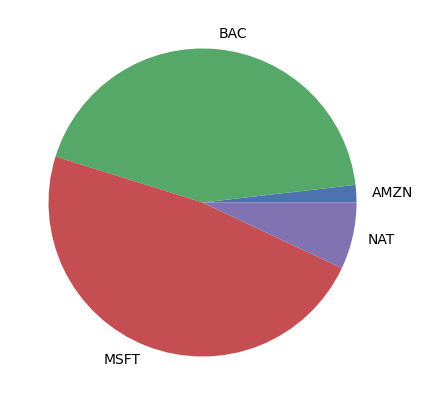

In [31]:
pd.Series(cleaned_weights).plot.pie(figsize=(5,5))

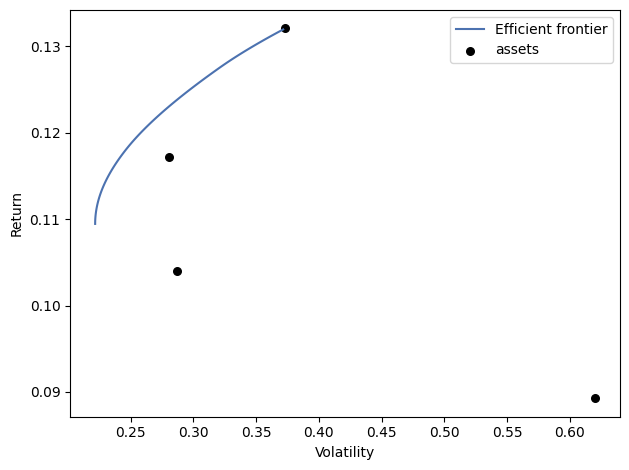

In [32]:
### Plot the Efficient Frontier (Bugfix)
### Change plt.style.use("seaborn-deep") to plt.style.use("seaborn-v0_8-deep") at line 21 of plotting.py
### You can find plotting.py in "~/venv/yourenvname/lib/python3.10/site-packages/pypfopt"

import matplotlib.pyplot as plt
from pypfopt import plotting

ef = EfficientFrontier(mu, Sigma)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()